**Persiapan**

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import splitfolders

**Mengunduh Dataset**

In [3]:
! chmod 600 /content/kaggle.json

In [4]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d rajkumar898/rice-plant-dataset

 99% 1.21G/1.23G [00:10<00:00, 131MB/s]
100% 1.23G/1.23G [00:10<00:00, 123MB/s]


In [5]:
#Mengekstrak gambar
zip_file = zipfile.ZipFile('/content/rice-plant-dataset.zip')
zip_file.extractall('/content')

In [7]:
#melakukan split data sebesar
#60% training dan 40% test
splitfolders.ratio('/content/Rice Seed Dataset', output="/content/datasplit",seed=999, ratio=(.6, .4))

Copying files: 1007 files [00:04, 212.32 files/s]


In [8]:
base_dir = '/content/datasplit'
folder_train = '/content/datasplit/train'
folder_validation = '/content/datasplit/val'

In [9]:
#Menghitung Jumlah pada Dataset
total_data = 0

# Iterasi semua file di dalam direktori
for root, dirs, files in os.walk(base_dir):
    total_data += len(files)

print("Jumlah total data:", total_data)

Jumlah total data: 1007


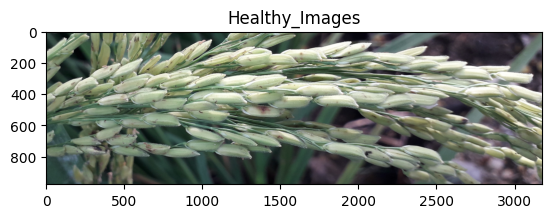

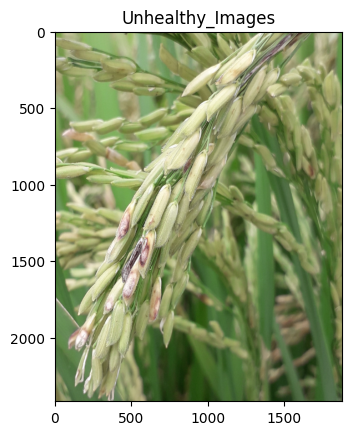

In [10]:
#Menampilkan gambar tiap kelas
for root, dirs, files in os.walk(folder_train):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        image_files = os.listdir(folder_path)
        if len(image_files) > 0:
            image_path = os.path.join(folder_path, image_files[0])
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(dir_name)
            plt.show()

**DATA PREPARATION**

In [11]:
IMAGE_SIZE = (250,250)
BATCH_SIZE = 32
SEED = 999

In [12]:
# Menggunakan ImageDataGenerator untuk preprocessing
imagegenerator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

In [13]:
# Image Data Generator pada Dataset
train_data = imagegenerator.flow_from_directory(
    folder_train,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

validation_data = imagegenerator.flow_from_directory(
    folder_validation,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 603 images belonging to 2 classes.
Found 404 images belonging to 2 classes.


In [14]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

**Model**

In [15]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 1s 0us/step


In [16]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [17]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=10,
    validation_data = validation_data
)

Epoch 1/10
19/19 [==============================] - 127s 5s/step - loss: 0.8103 - accuracy: 0.5655 - val_loss: 0.6017 - val_accuracy: 0.6658
Epoch 2/10
19/19 [==============================] - 83s 4s/step - loss: 0.5403 - accuracy: 0.7363 - val_loss: 0.5061 - val_accuracy: 0.7624
Epoch 3/10
19/19 [==============================] - 84s 5s/step - loss: 0.4567 - accuracy: 0.7960 - val_loss: 0.5199 - val_accuracy: 0.7327
Epoch 4/10
19/19 [==============================] - 84s 5s/step - loss: 0.4443 - accuracy: 0.7960 - val_loss: 0.4025 - val_accuracy: 0.8267
Epoch 5/10
19/19 [==============================] - 90s 5s/step - loss: 0.3817 - accuracy: 0.8458 - val_loss: 0.3725 - val_accuracy: 0.8391
Epoch 6/10
19/19 [==============================] - 83s 4s/step - loss: 0.3369 - accuracy: 0.8657 - val_loss: 0.3468 - val_accuracy: 0.8540
Epoch 7/10
19/19 [==============================] - 82s 4s/step - loss: 0.3229 - accuracy: 0.8590 - val_loss: 0.3375 - val_accuracy: 0.8713
Epoch 8/10
19/19 [=

In [ ]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Uji Coba**

In [ ]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

Saving he.jpg to he (1).jpg
1/1 [==============================] - 0s 39ms/step
he.jpg
The seed of rice plant is Healthy


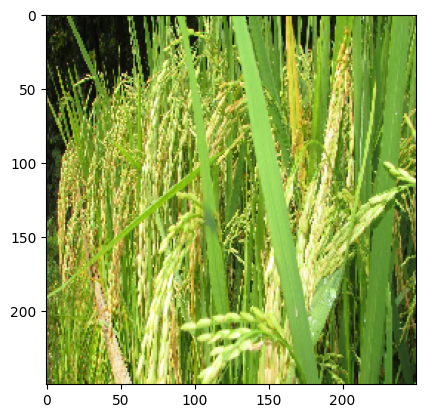

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # Memprediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes == 0:
    print('The seed of rice plant is Healthy') 
  else:
    print('The seed of rice plant is Unhealthy')